In [21]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text


input_path = '/shared/3/projects/hiatus/core-corpus/neurobiber_train.jsonl'

# Read JSONL file
df = pd.read_json(input_path, lines=True, orient='records')
print(len(df))
df.head()

ModuleNotFoundError: No module named 'adjustText'

In [2]:
df_exploded = df.explode('register')

# Reset the index to have clean consecutive indices
df_exploded = df_exploded.reset_index(drop=True)

# Display the first few rows to verify

# Create dictionary of register abbreviations to full names
register_dict = {
    'AD': 'advertisement',
    'AV': 'advice',
    'CM': 'course materials',
    'DF': 'discussion forum',
    'DP': 'description of a person',
    'DS': 'description with intent to sell',
    'DT': 'description of a thing',
    'ED': 'editorial',
    'EN': 'encyclopedia article',
    'FH': 'FAQ about how-to',
    'FI': 'FAQ about information',
    'FS': 'formal speech',
    'HA': 'historical article',
    'HI': 'how-to instructional',
    'HT': 'how-to',
    'IB': 'information blog',
    'ID': 'interactive discussion',
    'IN': 'informational description / explanation',
    'IP': 'informational persuasion',
    'IT': 'interview',
    'LE': 'letter to the editor',
    'LT': 'legal terms and conditions',
    'LY': 'lyrical',
    'MA': 'magazine article',
    'NA': 'narrative',
    'NE': 'news report / blog',
    'OB': 'opinion blog',
    'OE': 'other informational persuasion',
    'OF': 'other interactive discussion',
    'OH': 'other how-to / instructional',
    'OI': 'other informational description / explanation',
    'OL': 'other lyrical',
    'ON': 'other narrative',
    'OO': 'other opinion',
    'OP': 'opinion',
    'OS': 'other spoken',
    'OTHER': 'no labels',
    'PA': 'persuasive article or essay',
    'PB': 'personal blog',
    'PO': 'poem',
    'PR': 'prayer',
    'QA': 'question/answer forum',
    'RA': 'research article',
    'RE': 'recipe',
    'RR': 'reader/viewer responses',
    'RS': 'religious blogs / sermons',
    'RV': 'review',
    'SL': 'song lyric',
    'SP': 'spoken',
    'SR': 'sports report',
    'SS': 'short story',
    'TA': 'transcript of video / audio',
    'TB': 'travel blog',
    'TR': 'technical report',
    'TS': 'technical support',
    'TV': 'TV/movie script'
}

# Add new column with full register names
df_exploded['register_full'] = df_exploded['register'].map(register_dict)


df_exploded.head()

,doc_id,text,register,neural_tags,register_full
0,80683,Abstract Deficiens (defA+) is a homeotic gene ...,IN,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...",informational description / explanation
1,80683,Abstract Deficiens (defA+) is a homeotic gene ...,RA,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...",research article
2,48847,A Mt. San Jacinto College student is on a ques...,NA,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...",narrative
3,48847,A Mt. San Jacinto College student is on a ques...,NE,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...",news report / blog
4,3124905,The state of the railways The Treasury thought...,NA,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...",narrative


In [3]:
# Convert list of neural tags to numpy array for features
features = np.array(df_exploded['neural_tags'].tolist())

# Standardize the features (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Run PCA
n_components = 7
pca = PCA(n_components=n_components)
transformed_features = pca.fit_transform(features_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame({
    **{f'PC{i+1}': transformed_features[:, i] for i in range(n_components)},
    'register': df_exploded['register']  # Add register information
})

# Calculate means for each register
register_means = pca_df.groupby('register').agg({
    'PC1': 'mean',
    'PC2': 'mean'
}).reset_index()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


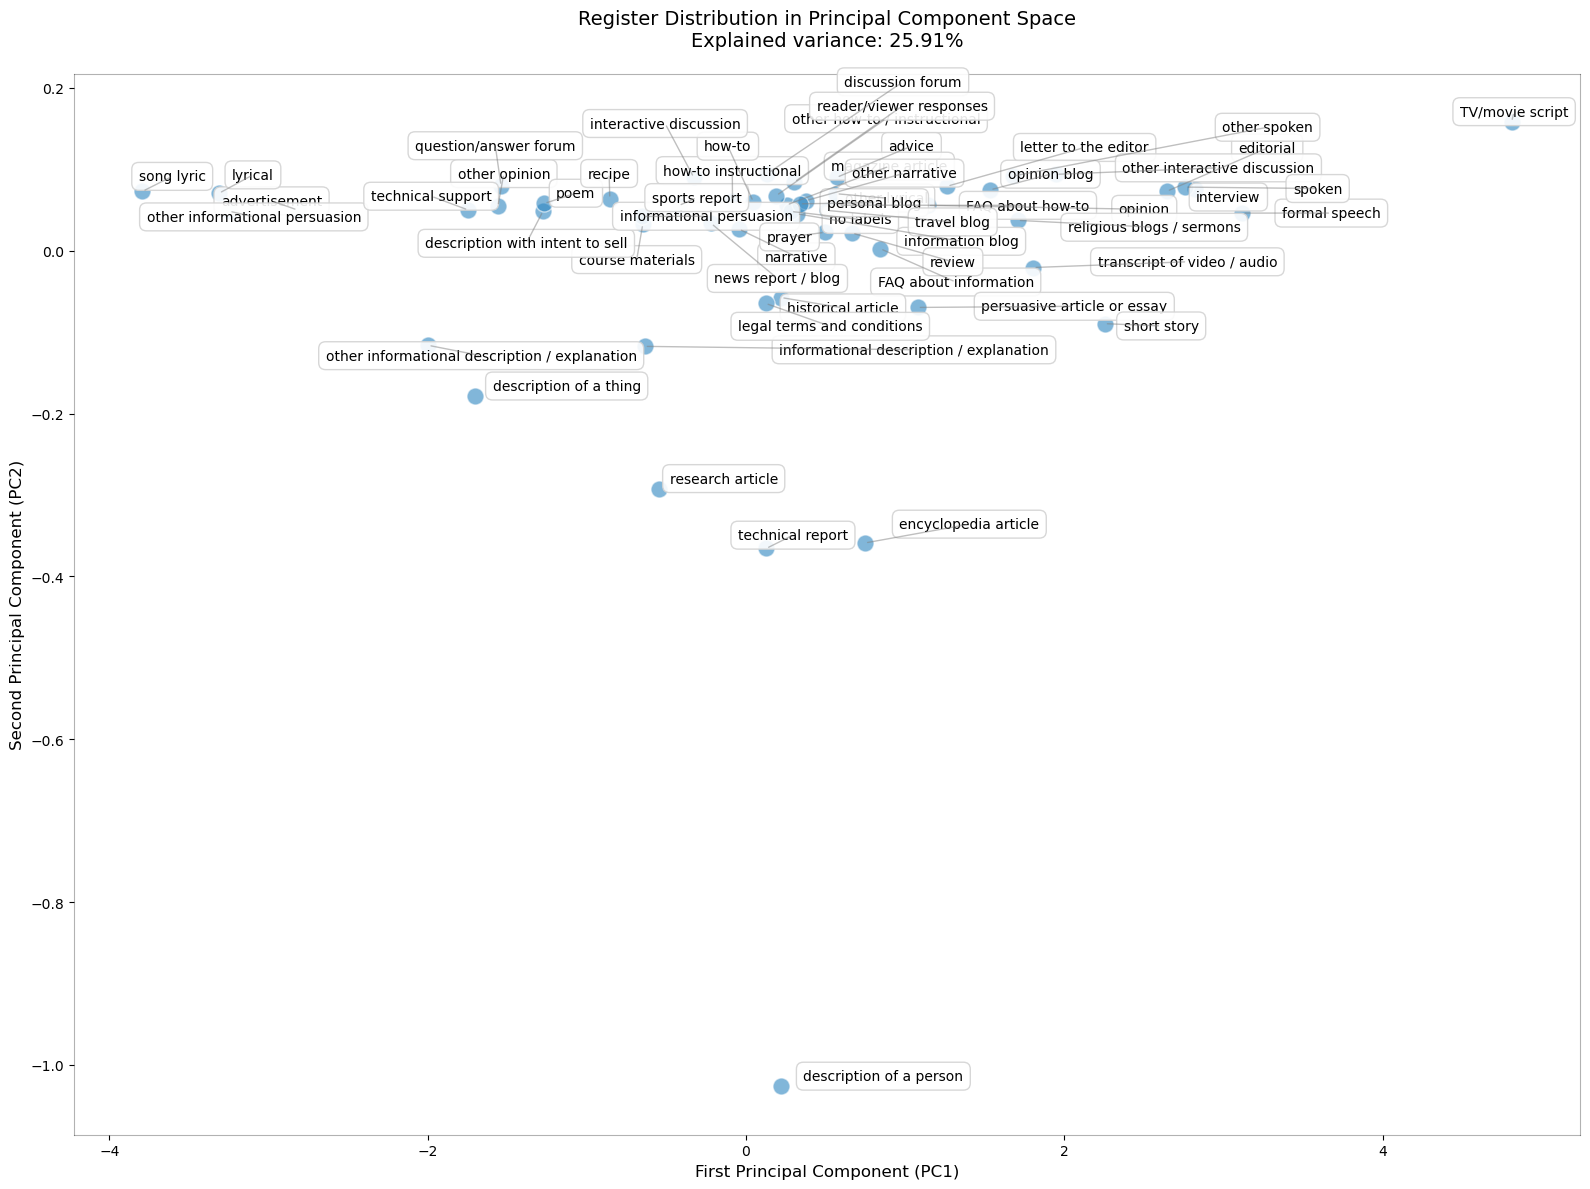

In [4]:
# Create the plot
plt.figure(figsize=(16, 12))

# Create the main scatter plot using seaborn
ax = sns.scatterplot(data=register_means, 
                     x='PC1', 
                     y='PC2',
                     s=150,
                     color='#2E86C1',
                     alpha=0.6)

# Create list to store text objects for adjust_text
texts = []

# Add labels with better formatting
for idx, row in register_means.iterrows():
    # Use register_dict to get full name
    full_name = register_dict[row['register']]
    text = plt.text(row['PC1'], row['PC2'], 
                   full_name,
                   fontsize=10,
                   bbox=dict(facecolor='white',
                            alpha=0.9,
                            edgecolor='lightgray',
                            boxstyle='round,pad=0.5'))
    texts.append(text)

# Use adjust_text to prevent overlap
adjust_text(texts, 
           arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
           expand_points=(1.5, 1.5))
           
# Customize the plot
plt.xlabel('First Principal Component (PC1)', fontsize=12)
plt.ylabel('Second Principal Component (PC2)', fontsize=12)

# Add explained variance to title
variance_text = f'Explained variance: {pca.explained_variance_ratio_[:2].sum():.2%}'
plt.title('Register Distribution in Principal Component Space\n' + variance_text, 
         fontsize=14, 
         pad=20)

# Add a subtle border around the plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_alpha(0.3)
ax.spines['right'].set_alpha(0.3)
ax.spines['left'].set_alpha(0.3)
ax.spines['bottom'].set_alpha(0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

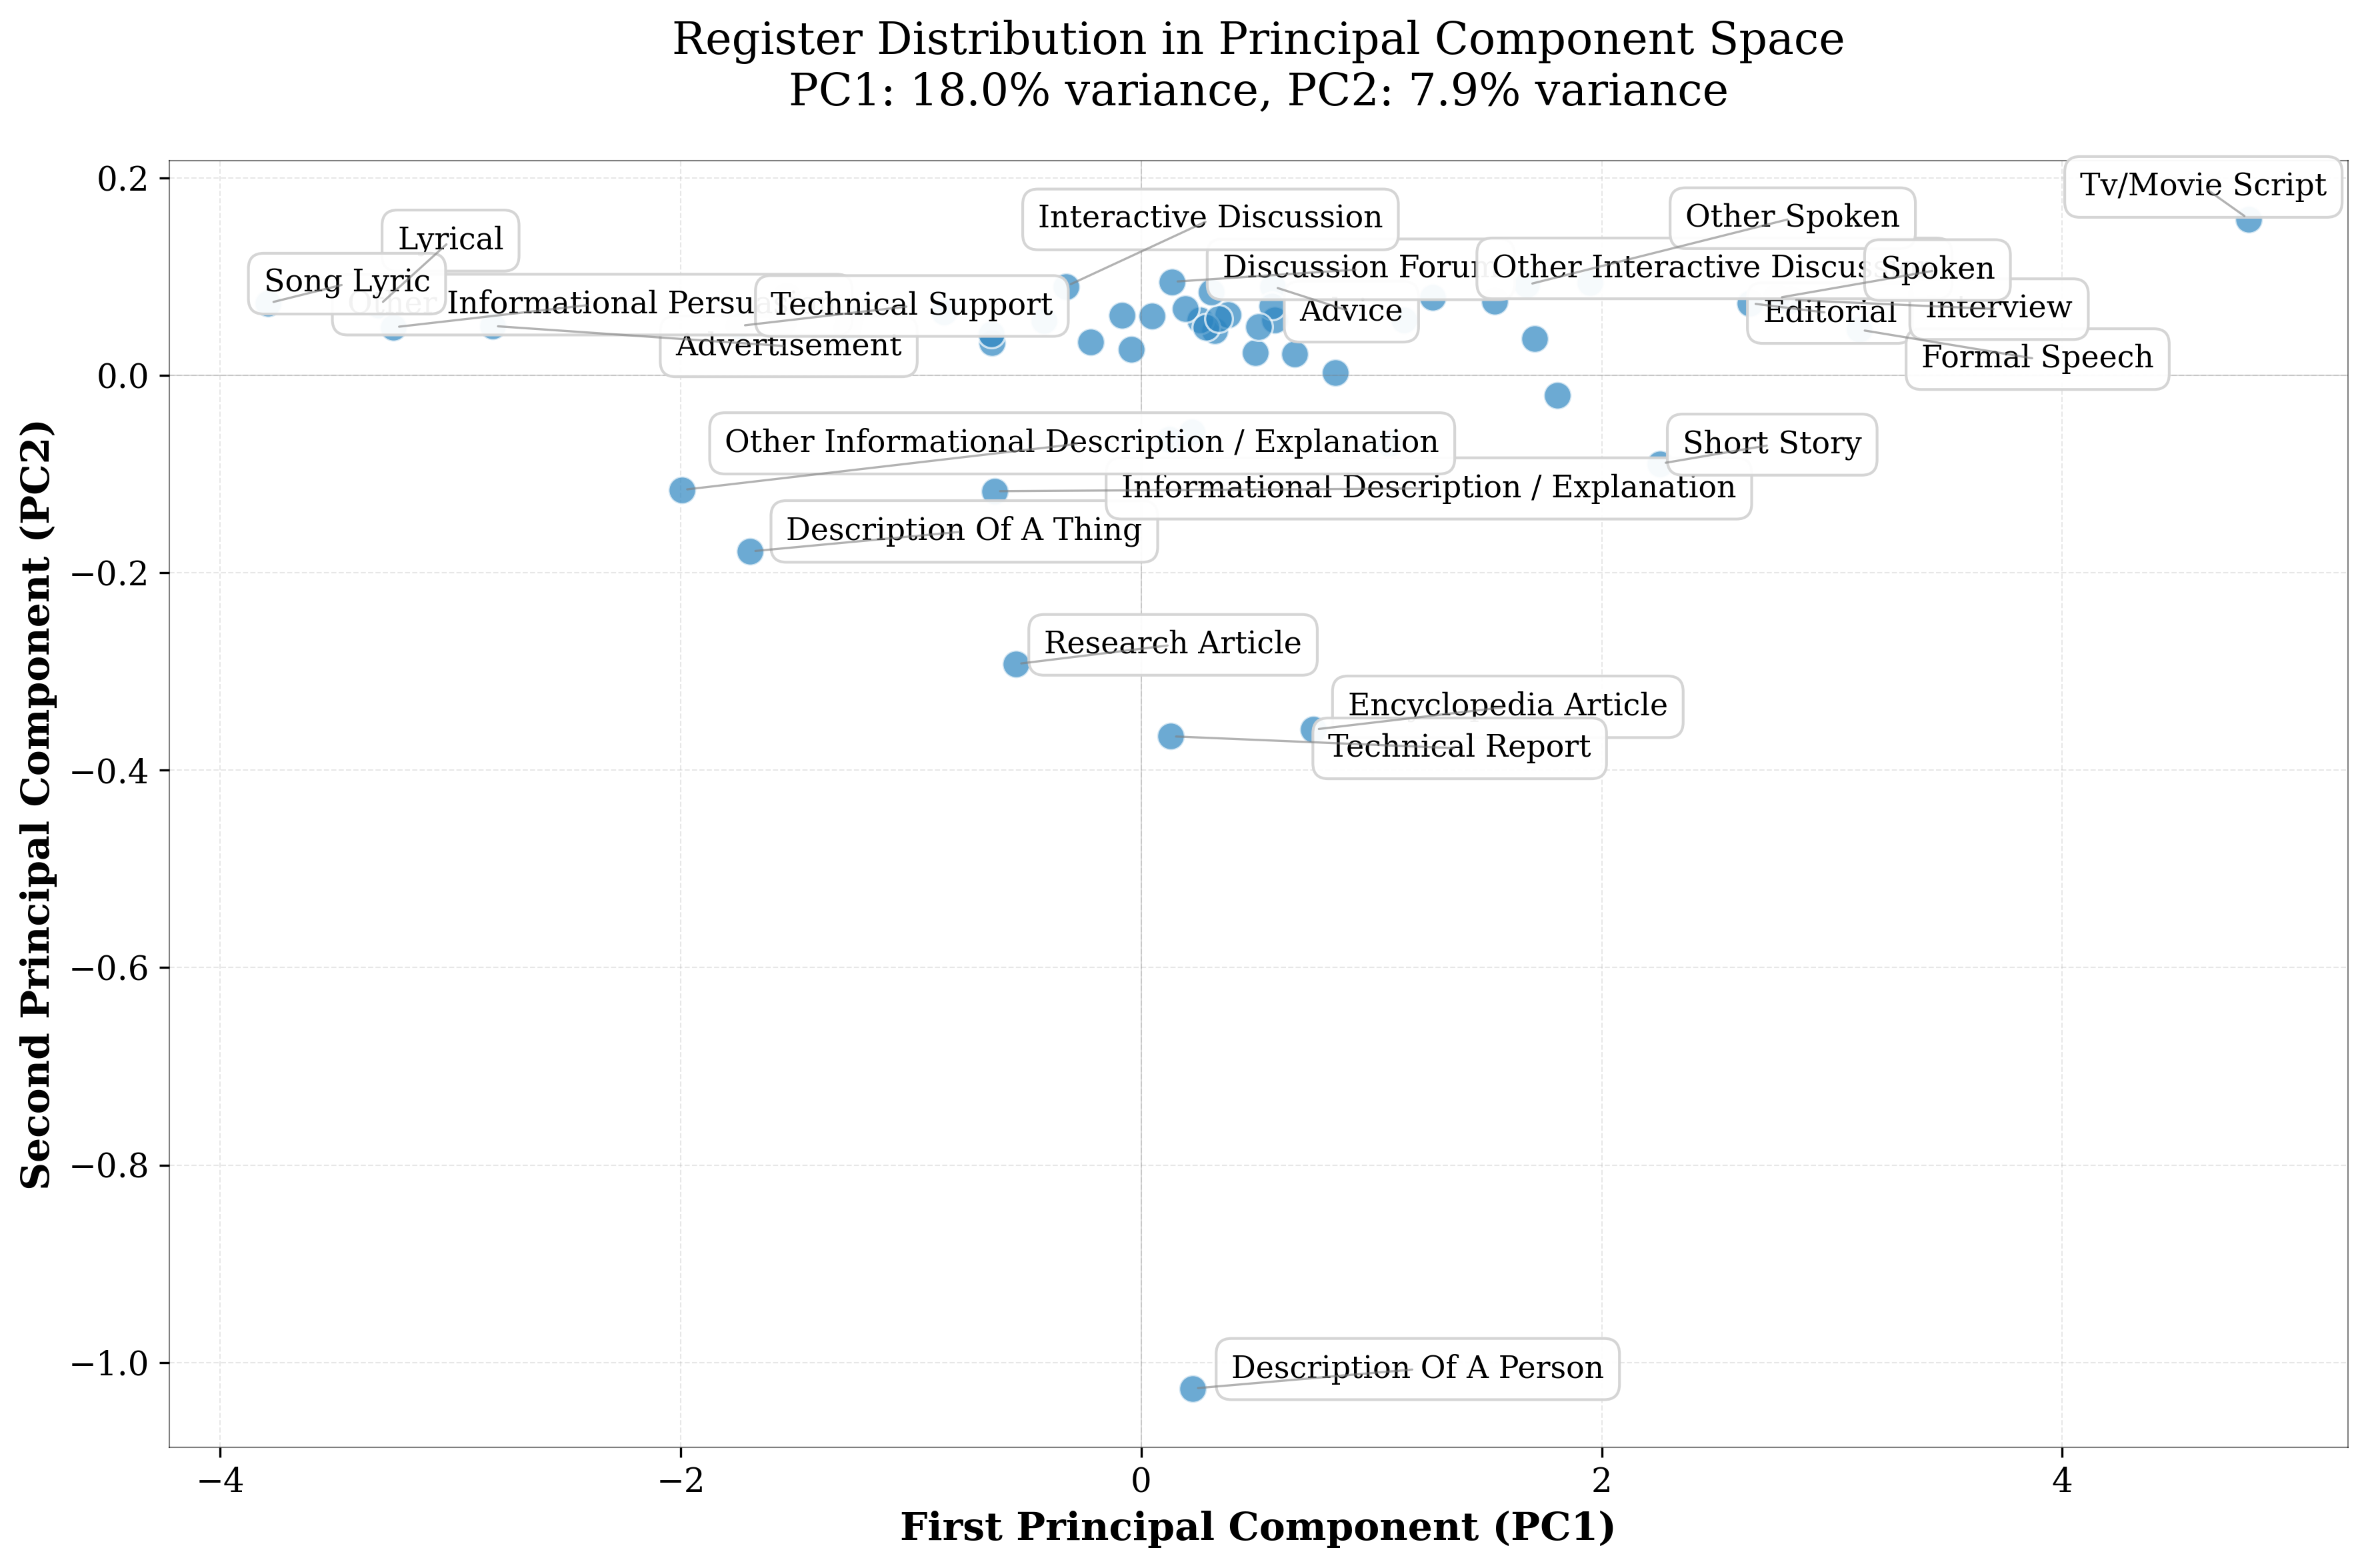

In [5]:
# Set the style and context for better readability
# plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Create figure with high DPI for crisp rendering
plt.figure(figsize=(12, 8), dpi=300)

# Calculate percentile thresholds
pc1_low, pc1_high = register_means['PC1'].quantile([0.1, 0.9])
pc2_low, pc2_high = register_means['PC2'].quantile([0.1, 0.9])

# Create the main scatter plot
ax = sns.scatterplot(data=register_means, 
                     x='PC1', 
                     y='PC2',
                     s=100,  # Slightly smaller points for better balance
                     color='#2E86C1',
                     alpha=0.7,
                     zorder=2)  # Ensure points are above grid lines

texts = []

# Add labels for extreme points
for idx, row in register_means.iterrows():
    if (row['PC1'] <= pc1_low or row['PC1'] >= pc1_high or 
        row['PC2'] <= pc2_low or row['PC2'] >= pc2_high):
        
        full_name = register_dict[row['register']]
        # Capitalize first letter of each word for better presentation
        full_name = full_name.title()
        
        text = plt.text(row['PC1'], row['PC2'], 
                       full_name,
                       fontsize=11,
                       bbox=dict(facecolor='white',
                               alpha=0.95,  # More opaque background
                               edgecolor='lightgray',
                               boxstyle='round,pad=0.5',
                               mutation_scale=0.8),  # Slightly smaller boxes
                       zorder=3)  # Ensure labels are on top
        texts.append(text)

# Adjust text with refined parameters
adjust_text(texts, 
           arrowprops=dict(arrowstyle='-',
                          color='gray',
                          alpha=0.6,
                          linewidth=0.8),
           expand_points=(1.7, 1.7),  # Slightly more spacing
           force_points=(0.5, 0.5))   # Balanced force between points and text

# Customize axes
plt.xlabel('First Principal Component (PC1)', fontweight='bold')
plt.ylabel('Second Principal Component (PC2)', fontweight='bold')

# Add explained variance to title with formatted percentages
variance_pc1 = pca.explained_variance_ratio_[0] * 100
variance_pc2 = pca.explained_variance_ratio_[1] * 100
title = f'Register Distribution in Principal Component Space\n'
subtitle = f'PC1: {variance_pc1:.1f}% variance, PC2: {variance_pc2:.1f}% variance'

plt.title(title + subtitle, pad=20)

# Refine grid and spines
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)
    spine.set_alpha(0.5)

# Add zero lines for reference
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Ensure proper layout
plt.tight_layout()

# Save the figure with high quality
plt.savefig('/home/kalkiek/projects/biber-multidimensional-register-analysis/experiments/register_variation/register_pca_distribution.pdf', 
            bbox_inches='tight', 
            dpi=300,
            format='pdf')

# Show plot
plt.show()

In [9]:

pca_means = pca_df.groupby('register').agg({
    f'PC{i+1}': 'mean' for i in range(n_components)
}).reset_index()

pca_means['register'] = pca_means['register'].map(register_dict)

pca_means.head()

,register,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,advertisement,-2.817857,0.050053,0.497726,0.020792,-0.127544,0.038555,0.350784
1,advice,0.569565,0.090126,0.513257,0.196832,-0.617608,0.073839,0.462116
2,course materials,-0.648254,0.032863,-0.613118,0.109561,0.049621,0.036007,-0.142623
3,discussion forum,0.133934,0.094743,1.397152,-0.109577,-0.362768,0.030549,0.090779
4,description of a person,0.222266,-1.026464,-0.447241,-0.189858,0.111582,-0.249853,-0.213676


In [10]:
# Create string representation of the DataFrame
df_string = pca_means.to_string(index=False)

# Print with proper formatting
print("```")
print(df_string)
print("```")

# Alternative version with more control over formatting
formatted_string = (pca_means
    .to_string(
        index=False,
        float_format=lambda x: '{:.3f}'.format(x),  # Format floats to 3 decimal places
        justify='left',                             # Left-align text
        col_space=12                               # Minimum column width
    )
)

print("\nAlternative formatting:")
print("```")
print(formatted_string)
print("```")

```
                                     register       PC1       PC2       PC3       PC4       PC5       PC6       PC7
                                advertisement -2.817857  0.050053  0.497726  0.020792 -0.127544  0.038555  0.350784
                                       advice  0.569565  0.090126  0.513257  0.196832 -0.617608  0.073839  0.462116
                             course materials -0.648254  0.032863 -0.613118  0.109561  0.049621  0.036007 -0.142623
                             discussion forum  0.133934  0.094743  1.397152 -0.109577 -0.362768  0.030549  0.090779
                      description of a person  0.222266 -1.026464 -0.447241 -0.189858  0.111582 -0.249853 -0.213676
              description with intent to sell -1.275306  0.048640  0.076809 -0.000871  0.080894  0.022809  0.156035
                       description of a thing -1.699746 -0.178431 -0.402247 -0.062896  0.354453  0.020375  0.111766
                                    editorial  2.644365  0.073059 -0

PC1 mostly separates registers that are interactive/narrative (positive) from those that are more expository, technical, or otherwise non-narrative (negative). This broad “involved vs. informational” split aligns fairly closely with Biber’s Dimension 1.

In Biber’s original Dimension 2, we often see a “narrative vs. non-narrative” distinction. Here, PC2 does capture some of that (e.g., negative loadings for expository or descriptive text), but it also seems to reflect an “interactive vs. edited/monologic” dimension. Interactions (forums, interviews, movie scripts) cluster on the positive side, whereas heavily edited or descriptive text goes negative.

1.	PC1 aligns well with Biber’s Dimension 1 (involved vs. informational). Texts recognized as conversational, informal, or narrative cluster on the positive side; expository/technical texts cluster on the negative side.
2.	PC2 partly resembles Biber’s Dimension 2, but with a noticeable tilt toward an interactive vs. edited split in your dataset. Rather than simply “narrative vs. non-narrative,” it blends aspects of dialogic structure, spontaneity, and the extent of editorial shaping.


### 1. Broad Alignment with Biber’s Dimensions
- **PC1**: Matches **Biber’s Dimension 1**—“Involved/Personal” vs. “Informational/Impersonal.”
- **PC2**: Partially overlaps with **Dimension 2**, showing an **Interactive/Dialogic** vs. **Edited/Monologic** distinction, nuanced by the dataset.

### 2. Nuances Due to the Corpus
- Unique registers like *song lyric*, *recipe*, and *advertisement* behave differently due to their **formulaic or creative linguistic features**.
- Specialized contrasts emerge, such as **persuasive/emotive vs. factual** and **spoken instructional vs. concise formulaic**.

### 3. Multiple Dimensions of “Narrative”
- Narrative features appear in multiple PCs:
  - **PC1**: Involved, storytelling-oriented.
  - **PC3**: Elaborated storytelling.
  - **PC5**: Rich, detailed narratives vs. formulaic structures.

### 4. Instructional vs. Formal Academic
- **PC4 and PC7** highlight distinctions between:
  - **Instructional/Procedural Text**: FAQs, how-to guides, and technical support.
  - **Formal/Academic Exposition**: Dense, planned texts like research articles and technical reports.

### 5. Additional Granular Dimensions
- PCs capture new stylistic contrasts:
  - **PC5**: Narrative-heavy vs. concise/formulaic text.
  - **PC6**: Persuasive/Promotional vs. Neutral/Factual.
  - **PC7**: Spoken/Instructional vs. Structured/Transactional.

### Summary
- **PC1 and PC2** align strongly with Biber’s classic findings, confirming the foundational distinctions of **involvement vs. information** and **dialogue vs. monologue**.
- **PC3–PC7** reflect corpus-specific nuances, emphasizing features like **narrative elaboration**, **instructional clarity**, and **persuasive stance**—key to modern, diverse datasets.